In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc

In [29]:
column_names = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 
               'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'class']

df = pd.read_csv('magic04.data', names=column_names)

df['class'] = df['class'].map({'g': 1, 'h': 0})

print("Missing values in each column:")
print(df.isnull().sum())

print("\nDataset Information:")
print(f"Number of samples: {df.shape[0]}")
print(f"Number of features: {df.shape[1] - 1}")
print(f"Class distribution:\n{df['class'].value_counts(normalize=True).mul(100).round(2)}")

print("\nSummary Statistics:")
print(df.describe())

X = df.drop('class', axis=1)
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Missing values in each column:
fLength     0
fWidth      0
fSize       0
fConc       0
fConc1      0
fAsym       0
fM3Long     0
fM3Trans    0
fAlpha      0
fDist       0
class       0
dtype: int64

Dataset Information:
Number of samples: 19020
Number of features: 10
Class distribution:
class
1    64.84
0    35.16
Name: proportion, dtype: float64

Summary Statistics:
            fLength        fWidth         fSize         fConc        fConc1  \
count  19020.000000  19020.000000  19020.000000  19020.000000  19020.000000   
mean      53.250154     22.180966      2.825017      0.380327      0.214657   
std       42.364855     18.346056      0.472599      0.182813      0.110511   
min        4.283500      0.000000      1.941300      0.013100      0.000300   
25%       24.336000     11.863800      2.477100      0.235800      0.128475   
50%       37.147700     17.139900      2.739600      0.354150      0.196500   
75%       70.122175     24.739475      3.101600      0.503700      0.285225  

In [30]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machine': SVC(probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'saga']
    },
    'K-Nearest Neighbors': {
        'n_neighbors': [3, 5, 7, 9, 11, 13],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'Support Vector Machine': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto', 0.1, 0.01]
    },
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0]
    }
}

In [31]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }

In [32]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_models = {}
model_results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train_scaled, y_train)
    
    best_model = grid_search.best_estimator_
    best_models[name] = best_model
    
    model_results[name] = evaluate_model(best_model, X_test_scaled, y_test)
    
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best cross-validation ROC AUC: {grid_search.best_score_:.4f}")
    print(f"Test set performance for {name}:")
    for metric, value in model_results[name].items():
        print(f"  {metric}: {value:.4f}")


Training Logistic Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for Logistic Regression: {'C': 0.1, 'solver': 'saga'}
Best cross-validation ROC AUC: 0.8442
Test set performance for Logistic Regression:
  Accuracy: 0.7808
  Precision: 0.7923
  Recall: 0.8970
  F1 Score: 0.8414
  ROC AUC: 0.8276

Training K-Nearest Neighbors...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters for K-Nearest Neighbors: {'metric': 'manhattan', 'n_neighbors': 13, 'weights': 'distance'}
Best cross-validation ROC AUC: 0.9037
Test set performance for K-Nearest Neighbors:
  Accuracy: 0.8412
  Precision: 0.8214
  Recall: 0.9649
  F1 Score: 0.8874
  ROC AUC: 0.8990

Training Support Vector Machine...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


/opt/homebrew/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters for Support Vector Machine: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best cross-validation ROC AUC: 0.9218
Test set performance for Support Vector Machine:
  Accuracy: 0.8747
  Precision: 0.8613
  Recall: 0.9616
  F1 Score: 0.9087
  ROC AUC: 0.9284

Training Random Forest...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation ROC AUC: 0.9329
Test set performance for Random Forest:
  Accuracy: 0.8840
  Precision: 0.8848
  Recall: 0.9441
  F1 Score: 0.9134
  ROC AUC: 0.9374

Training Gradient Boosting...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best cross-validation ROC AUC: 0.9328
Test set performance for Gradient Boosting:
  Accuracy: 0.8894
  Precision: 0.8918
  Recall: 0.9441
 


Model Comparison:
                        Accuracy  Precision    Recall  F1 Score   ROC AUC
Logistic Regression     0.780757   0.792313  0.897027  0.841425  0.827570
K-Nearest Neighbors     0.841220   0.821445  0.964865  0.887397  0.899009
Support Vector Machine  0.874693   0.861293  0.961622  0.908696  0.928370
Random Forest           0.883982   0.884752  0.944054  0.913441  0.937422
Gradient Boosting       0.889415   0.891754  0.944054  0.917159  0.937996

Best model: Gradient Boosting with ROC AUC of 0.9380


<Figure size 1200x800 with 0 Axes>

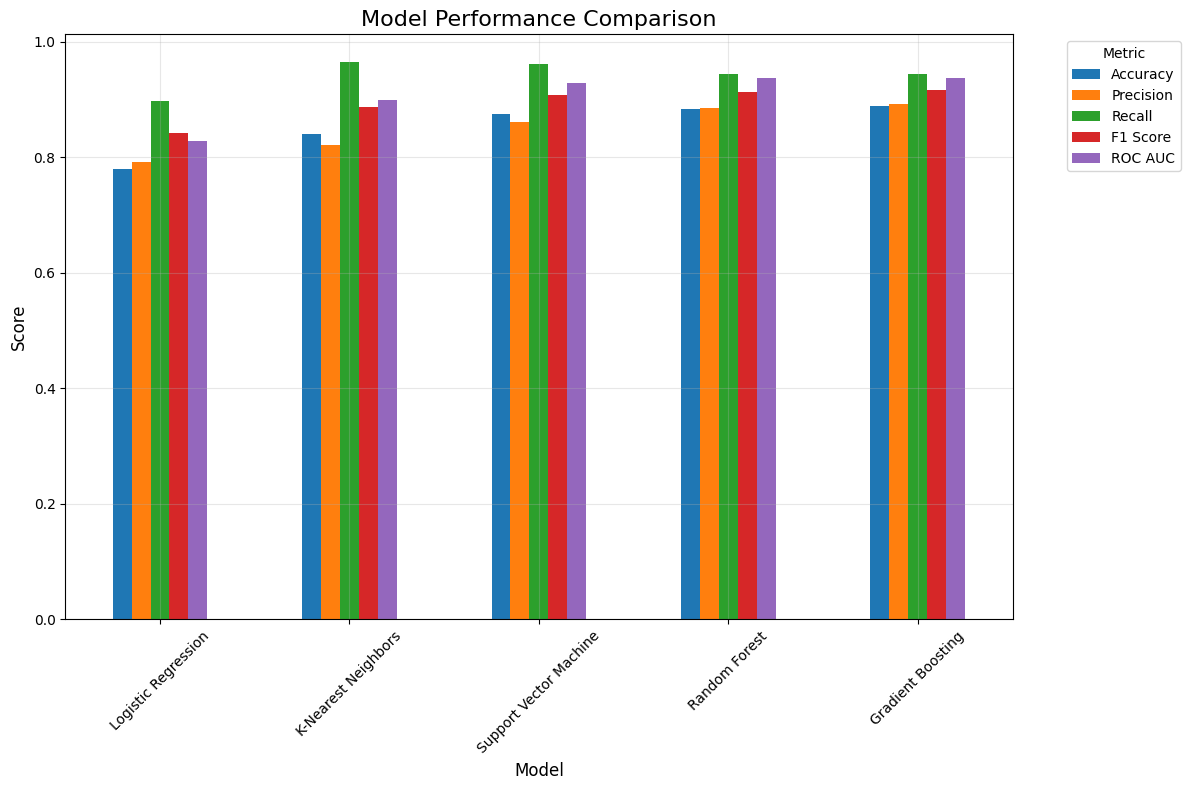

In [33]:
model_comparison = pd.DataFrame(model_results).T
print("\nModel Comparison:")
print(model_comparison)

# Best model based on ROC AUC
best_model_name = model_comparison['ROC AUC'].idxmax()
best_model = best_models[best_model_name]

print(f"\nBest model: {best_model_name} with ROC AUC of {model_comparison.loc[best_model_name, 'ROC AUC']:.4f}")

# Bar plot for model performances
plt.figure(figsize=(12, 8))
model_comparison.plot(kind='bar', figsize=(12, 8))
plt.title('Model Performance Comparison', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.savefig('model_comparison.png', dpi=300)
plt.show()

### Model Evaluation with Confusion Matrix

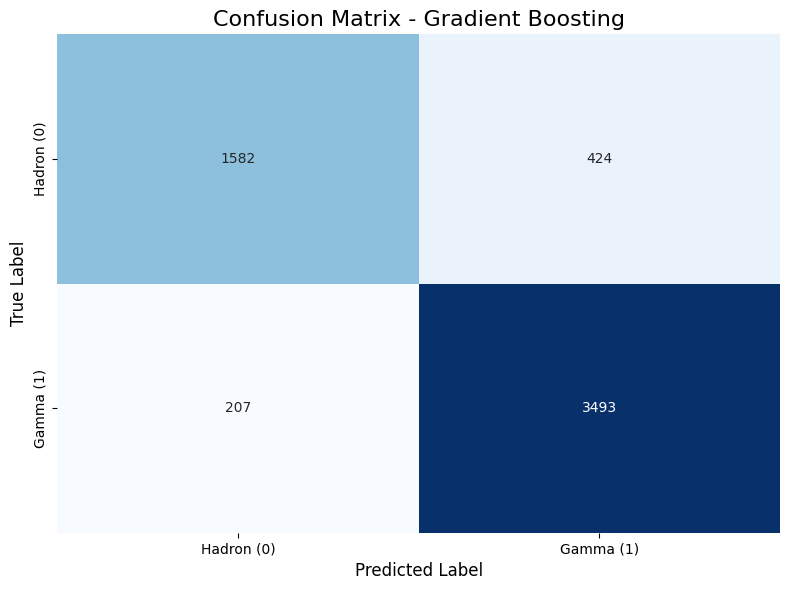

In [34]:
y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks([0.5, 1.5], ['Hadron (0)', 'Gamma (1)'])
plt.yticks([0.5, 1.5], ['Hadron (0)', 'Gamma (1)'])
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

### ROC Curve

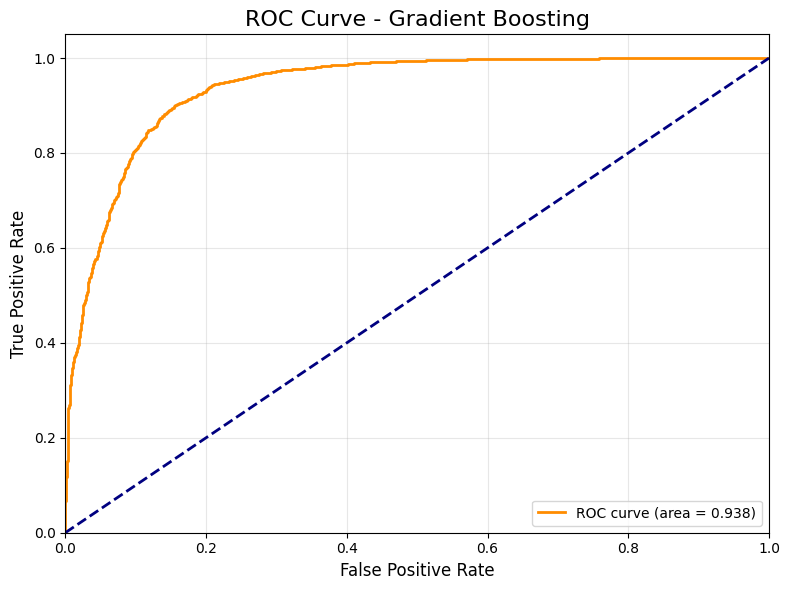

In [39]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'ROC Curve - {best_model_name}', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=300)
plt.show()

### Classification Report

In [40]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.79      0.83      2006
           1       0.89      0.94      0.92      3700

    accuracy                           0.89      5706
   macro avg       0.89      0.87      0.88      5706
weighted avg       0.89      0.89      0.89      5706



### Feature importance for tree-based models

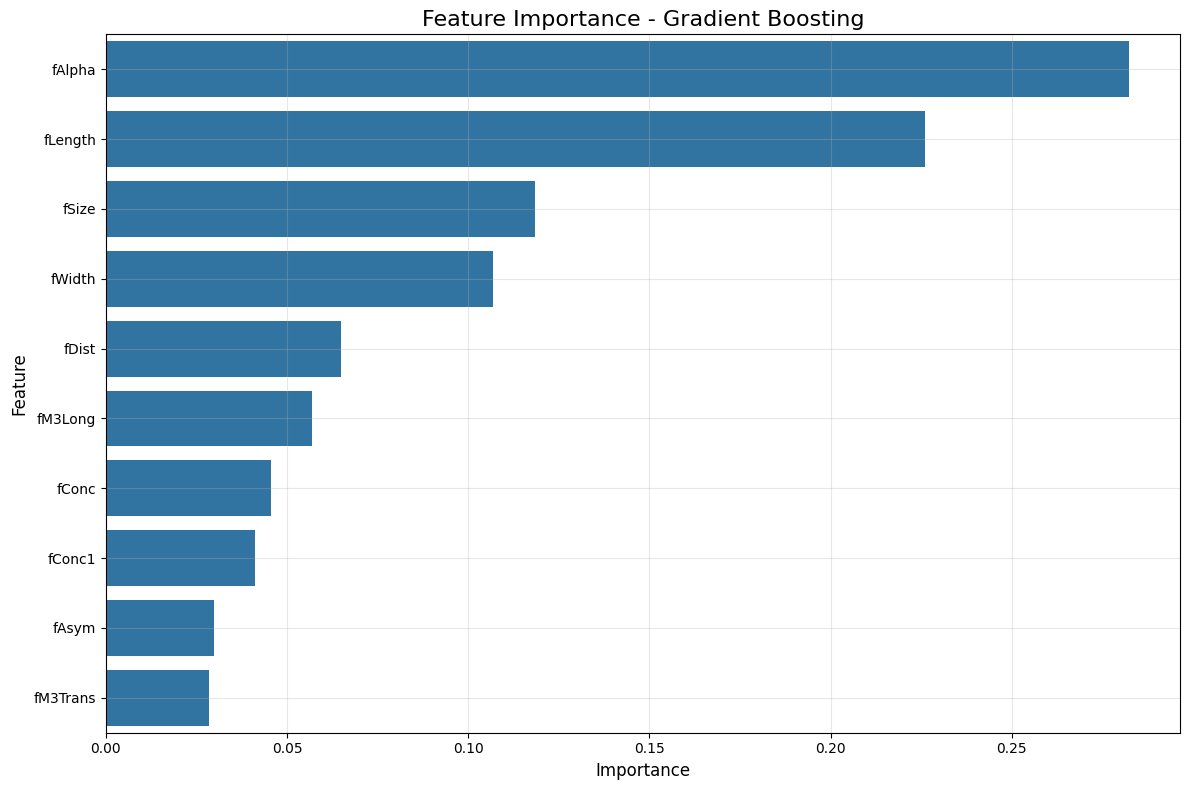


Feature Importance:
    Feature  Importance
8    fAlpha    0.282273
0   fLength    0.225922
2     fSize    0.118387
1    fWidth    0.106784
9     fDist    0.064920
6   fM3Long    0.056906
3     fConc    0.045537
4    fConc1    0.041064
5     fAsym    0.029779
7  fM3Trans    0.028429


In [41]:
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    feature_importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.title(f'Feature Importance - {best_model_name}', fontsize=16)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.grid(True, alpha=0.3)
    plt.savefig('feature_importance.png', dpi=300)
    plt.show()
    
    print("\nFeature Importance:")
    print(feature_importance_df)
elif best_model_name == 'Logistic Regression':
    coefficients = best_model.coef_[0]
    coefficient_df = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': coefficients
    }).sort_values(by='Coefficient', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Coefficient', y='Feature', data=coefficient_df)
    plt.title(f'Feature Coefficients - {best_model_name}', fontsize=16)
    plt.xlabel('Coefficient', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.grid(True, alpha=0.3)
    plt.savefig('feature_coefficients.png', dpi=300)
    plt.close()
    
    print("\nFeature Coefficients:")
    print(coefficient_df)

### Performance Metrics

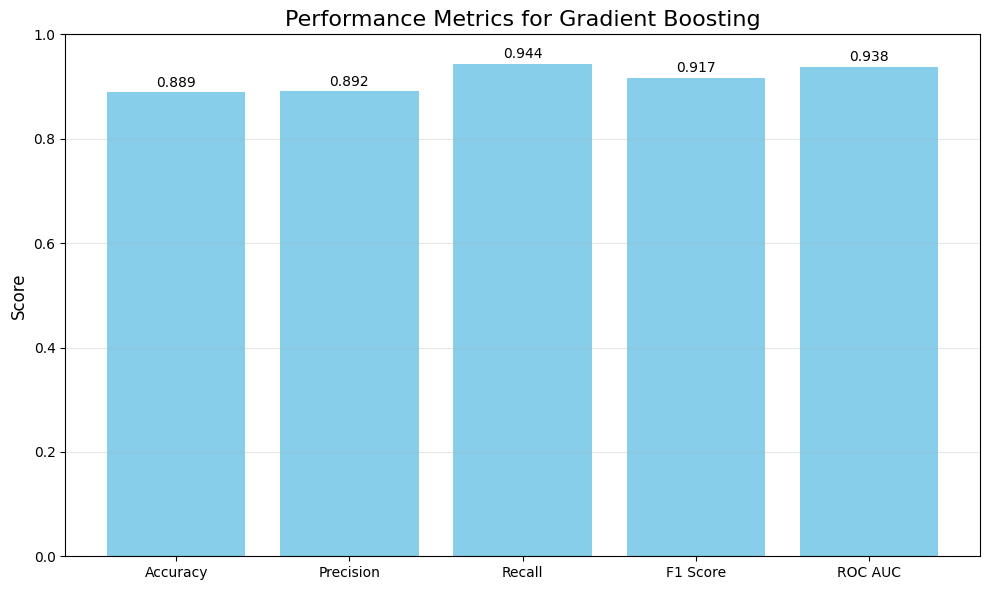

In [42]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
values = [model_results[best_model_name][metric] for metric in metrics]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color='skyblue')
plt.ylim(0, 1.0)
plt.title(f'Performance Metrics for {best_model_name}', fontsize=16)
plt.ylabel('Score', fontsize=12)
plt.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('performance_summary.png', dpi=300)
plt.show()

In [ ]:
# Final production ready pipeline code

In [ ]:
# Save best model